 In the context of scientific models, we have  three  fundamental kinds of statistical error:
 
(1) Overfitting, which leads to poor prediction by learning too much from the data (including all the features)

(2) Underfitting, which leads to poor prediction by learning too little from the data 

(3)Confounding. 

 Confounded models can in fact produce better predictions than models that correctly measure a causal relationship. The consequence of this is that, when we design any particular statistical model, we must decide whether we want to understand causes or rather just predict. 

These are not the same goal, and different models are needed for each.
However, to accurately measure a causal influence, we still have to deal with overfitting. The
monsters of overfitting and underfitting are always lurking, no matter the goal.


There are two common families of approaches: The first approach is to use a <b>regularizing prior</b> to tell the model not to get too excited by the data  (non-Bayesian methods refer to as “penalized likelihood.”)
The second approach is to use some scoring device, like <b>information criteria or cross validation</b>, to model the prediction task and estimate predictive accuracy. Both families of approaches are routinely used in the natural and social sciences.
Furthermore, they can be—maybe should be—used in combination. 
So it’s worth understanding both, as you’re going to need both at some point

<h3>Adding parameters</h3>

So is just adding everything to the model okay?
The answer is “no.” :
The first is that adding parameters—making the model more complex—nearly always <b>improves the fit</b> of a model to the data. By “fit” I mean a measure of how well the model can retrodict the data used to fit the model.

Second, while more complex models fit the data better, they often predict new data
worse. Models that have many parameters tend to overfit more than simpler models. This
means that a complex model will be very sensitive to the exact sample used to fit it, leading
to potentially large mistakes when future data is not exactly like the past data. But simple
models, with too few parameters, tend instead to underfit, systematically over-predicting or
under-predicting the data, regardless of how well future data resemble past data. So we can’t
always favor either simple models or complex models.


<h2> A simple Measure of fit R^2</h2>

R^2= 1 −var(residuals)/var(outcome)

R'2 increases as  more predictor variables are added. This is true even when the variables you add to a model
are just random numbers, with no relation to the outcome. So it’s no good to choose among
models using only fit to the data.


<h2>Overfitting Example</h2>

In [14]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf

from patsy import dmatrix
from scipy import stats
from scipy.special import logsumexp


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


AttributeError: module 'arviz' has no attribute 'geweke'

In [ ]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # set credible interval for entire notebook
np.random.seed(0)

In [5]:
brains = pd.DataFrame.from_dict(
    {
        "species": [
            "afarensis",
            "africanus",
            "habilis",
            "boisei",
            "rudolfensis",
            "ergaster",
            "sapiens",
        ],
        "brain": [438, 452, 612, 521, 752, 871, 1350],  # volume in cc
        "mass": [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5],  # mass in kg
    }
)


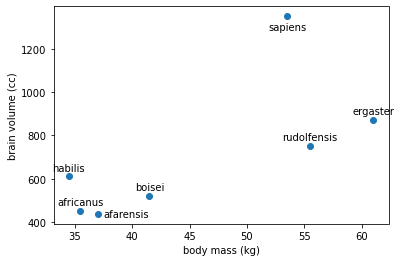

In [6]:
# Figure 7.2

plt.scatter(brains.mass, brains.brain)

# point labels
for i, r in brains.iterrows():
    if r.species == "afarensis":
        plt.text(r.mass + 0.5, r.brain, r.species, ha="left", va="center")
    elif r.species == "sapiens":
        plt.text(r.mass, r.brain - 25, r.species, ha="center", va="top")
    else:
        plt.text(r.mass, r.brain + 25, r.species, ha="center")

plt.xlabel("body mass (kg)")
plt.ylabel("brain volume (cc)");

<b> Fit models do data </b>

In order to see overfitting we will fit different models and calculate the R^2 for each. But before standardize!



In [8]:
brains.loc[:, "mass_std"] = (brains.loc[:, "mass"] - brains.loc[:, "mass"].mean()) / brains.loc[
    :, "mass"
].std()  # this guy is standardized -> centered around 0

brains.loc[:, "brain_std"] = brains.loc[:, "brain"] / brains.loc[:, "brain"].max() # this guy is not standardized
# but scaled-> lets us keep the 0 as refrece point  

In [9]:
#brain_std=a+b*mass_std
#with flat priors they are equivalent
m_7_1 = smf.ols("brain_std ~ mass_std", data=brains).fit()
m_7_1.summary()

NameError: name 'smf' is not defined

In [10]:
m_7_2 = smf.ols("brain_std ~ mass_std + I(mass_std**2)", data=brains).fit()
m_7_2.summary()


NameError: name 'smf' is not defined

In [11]:
m_7_3 = smf.ols("brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3)", data=brains).fit()
m_7_4 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4)",
    data=brains,
).fit()
m_7_5 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5)",
    data=brains,
).fit()

NameError: name 'smf' is not defined

In [12]:
m_7_6 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5) + I(mass_std**6)",
    data=brains,
).fit()

NameError: name 'smf' is not defined

In [13]:
models = [m_7_1, m_7_2, m_7_3, m_7_4, m_7_5, m_7_6]
names = ["m_7_1", "m_7_2", "m_7_3", "m_7_4", "m_7_5", "m_7_6"]

mass_plot = np.linspace(33, 62, 100)# produce values of brain mass onth original scale
mass_new = (mass_plot - brains.mass.mean()) / brains.mass.std()#standirdize it

fig, axs = plt.subplots(3, 2, figsize=[6, 8.5], sharex=True, sharey="row")

for model, name, ax in zip(models, names, axs.flat):
    prediction = model.get_prediction({"mass_std": mass_new})
    pred = prediction.summary_frame(alpha=0.11) * brains.brain.max()

    ax.plot(mass_plot, pred["mean"])
    ax.fill_between(mass_plot, pred["mean_ci_lower"], pred["mean_ci_upper"], alpha=0.3)
    ax.scatter(brains.mass, brains.brain, color="C0", s=15)

    ax.set_title(f"{name}: R^2: {model.rsquared:.2f}", loc="left", fontsize=11)

    if ax.is_first_col():
        ax.set_ylabel("brain volume (cc)")

    if ax.is_last_row():
        ax.set_xlabel("body mass (kg)")

    if ax.is_last_row():
        ax.set_ylim(-500, 2100)
        ax.axhline(0, ls="dashed", c="k", lw=1)
        ax.set_yticks([0, 450, 1300])
    else:
        ax.set_ylim(300, 1600)
        ax.set_yticks([450, 900, 1300])

fig.tight_layout()

NameError: name 'm_7_1' is not defined

In the previous example, it is more or less easy to see that first  model is very simple
and that the last model model is too complex for the data, but what about the other two? To
answer this question, we need a more principled way of taking into account the accuracy
on one side and the simplicity on the other. To do so, we will need to introduce several new
concepts. The first two are:

<b>Within-sample accuracy:</b> 
The accuracy measured with the data that's used to fit a model

<b>Out-of-sample accuracy:</b>
The accuracy of the model that's measured on data that is not used for fitting the model—this is also known as predictive accuracy


(i)For any combination of data and models, the within-sample accuracy will be, on average,
smaller than the out-of-sample accuracy :out-of sample measures are preferred over within-sample measures. However, generally, there is a problem with this. We need to be able to afford leaving aside a portion of the data—not to fit the model, but to test it.

To circumvent this problem, people have spent a lot of effort devising methods to estimate the out-of-sample
predictive accuracy using only within-sample data. Two such methods for this are:
<b>Cross-validation</b> and  <b>information criteria</b> 


<b>Cross-Validation</b> 
Take data and partition it into <b>K</b> portions.
Use <b>K-1</b> of  them to train the model and the remaining to test it. 
Then, repeat this procedure systematically by leaving a different portion out of the training set and using
that portion as the test set until we have done rounds.
The results,A<sub>K</sub> , are then averaged
along the K runs. This is known as K-fold cross-validation. When K is equal to the number
of data points, we get what is known as leave-one-out cross-validation (LOOCV).


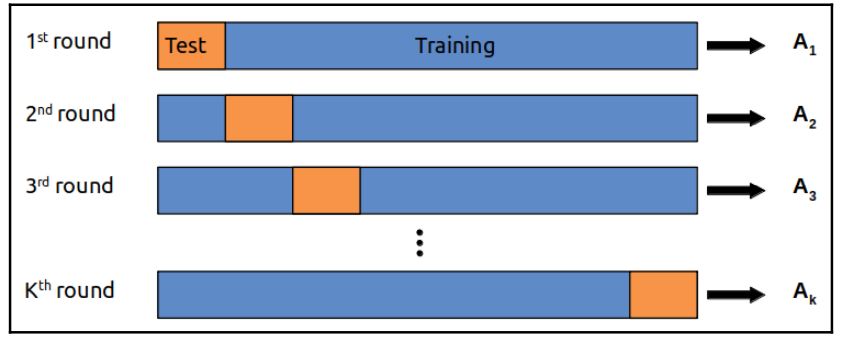

<h2>Information criteria</h2>
Information criteria is a collection of different and somehow related tools that are used to
compare models in terms of how well they fit the data while taking into account their
complexity through a penalization term. 


<h3>Log-likelihood and deviance </h3>
quadratic mean error:

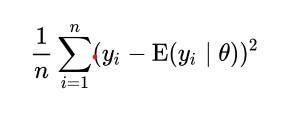

Log likelyhood:

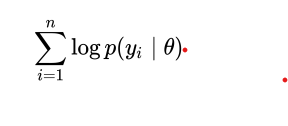
if likelyhood is gaussian log likely hood is proportional to quadratic mean error

In practice, and for historical reasons, log-likelihood is not used directly;
instead,  quantity known as deviance is used:

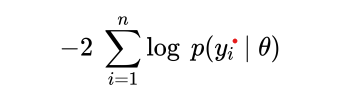



The deviance is used for Bayesians and non-Bayesians alike; the difference is that under a
Bayesian framework, is estimated from the posterior and, like any quantity derived from a
posterior, it has a <b>distribution</b>. On the contrary, in non-Bayesian settings, is a <b>point</b>
estimate. 
Wwo key aspects of deviance :
 The lower the deviance, the higher the log-likelihood and the higher the
agreement of the model predictions and the data. Therefore, we want low
deviance values.

 The deviance is measuring the <b>within-sample</b> accuracy of the model and hence
complex models will generally have a lower deviance than simpler ones. Thus,
we need to somehow include a penalization term for complex models.
<h3>Akaike information criterion </h3>

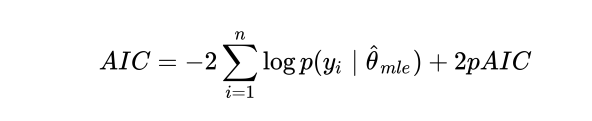


-pAic  is just the number of parameters and  &Theta;<sub>mle</sub> hat  is the maximum likelihood estimation
of &Theta .

Maximum likelihood estimation is a common practice for non-Bayesians and, in general, is equivalent to the Bayesian maximum a posteriori (MAP) estimation when using flat priors.

Notice that is a point estimation and not a distribution.

Hence, if two models explain the data equally well, but one has more parameters than the other, tells us that we should choose the one with the fewer parameters


<h3> Widely applicable Information Criterion</h3>
This is the fully<b>Bayesian</b> version of AIC.
Like with , the widely applicable information criterion (WAIC) has two terms: one that measures how well the data fits the model and one penalizing complex models:

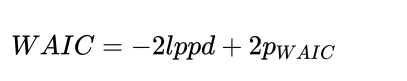

<h3> Pareto smoothed importance sampling leave one-out cross-validation </h3>
    
    Pareto smoothed importance sampling leave-one-out cross-validation (LOO-CV) is a method that's used to approximate the LOO-CV results but without actually performing the K iterations.
    
    The key trouble with leave-one-out cross-validation is that, if we have 1000 observations, that means computing 1000 posterior distributions. That can be time consuming. 
   
    Luckily, there are clever ways to approximate the cross-validation score without actually running the
model over and over again. One approach is to use the “importance” of each observation to the posterior distribution.
   
    What “importance” means here is that some observations have a larger impact on the posterior distribution—if we remove an important observation, the posterior changes more. Other observations have less impact. It is a benign aspect of the universe that this importance can be estimated without refitting the model.
    
    The key intuition is that an observation that is relatively unlikely is more important than one that is relatively expected. When your expectations are violated, you should change your expectation more.
 This importance is often called a weight, and these weights can be used to estimate a model’s out-of-sample accuracy.
    
    PSIS uses importance sampling,which just means that it uses the importance weights approach described in the previous paragraph. The Pareto-smoothing is a technique for making the importance weights more
reliable. PSIS uses Pareto  distribution to derive more reliable cross-validation score, without actually doing any cross-validation.
    But the best feature of PSIS is that it provides feedback about its own reliability. It does
this by noting particular observations with very high weights that could make the PSIS score
inaccurate. 
    

<h3>Model comparison with PyMC3</h3>
 Arviz have convaniance tools for waic(az.waic) and psislo(az.loo)    
 waic_l = az.waic(trace_l) 

For WAIC and LOO PyMC3 reports four values:
A point estimate
The standard error of the point estimate (this is computed by assuming
normality and hence it may not be very reliable when the sample size is low)
The effective number of parameters
A warning 



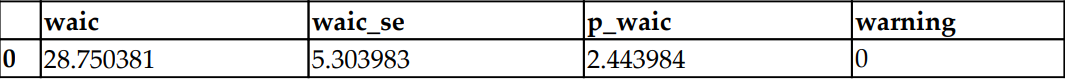

Since the values of WAIC/LOO are always interpreted in a relative fashion, that is, by
comparing them across models, ArviZ provides two auxiliary functions to ease the
comparison. The first one is az.compare:<br>
cmp_df = az.compare({'model_l':trace_l, 'model_p':trace_p}, method='BB-pseudo-BMA') <br>
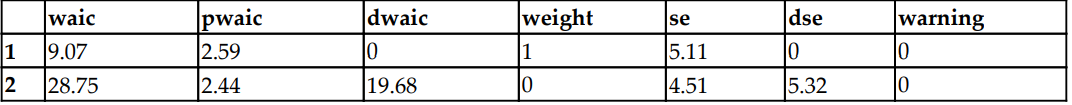


1. The first column clearly contains the values of WAIC. The DataFrame is always
sorted from the lowest to the highest WAIC. The index reflects the order in which
the models are passed to this function.
2. The second column is the estimated effective number of parameters. In general,
models with more parameters will be more flexible to fit data and at the same
time could also lead to overfitting. Thus, we can interpret pWAIC as a
penalization term. Intuitively, we can also interpret it as a measure of how
flexible each model is in fitting the data.
3. The third column is the relative difference between the value of WAIC for the
top-ranked model and the value of WAIC for each model. For this reason, we
will always get a value of 0 for the first model.
4. Sometimes, when comparing models, we do not want to select the best model.
Instead, we want to perform predictions by averaging along all the models (or at
least several models). Ideally, we would like to perform a weighted average,
giving more weight to the model that seems to explain/predict the data better.
There are many approaches to perform this task. One of them is to use Akaike
weights based on the values of WAIC for each model. These weights can be
loosely interpreted as the probability of each model (among the compared
models), given the data. One caveat of this approach is that the weights are based
on point estimates of WAIC (that is, the uncertainty is ignored).
5. The fifth column records the standard error for the WAIC computations. The
standard error can be useful for assessing the uncertainty of the WAIC estimates.
6. In the same way that we can compute the standard error for each value of WAIC,
we can compute the standard error of the differences between two values of
WAIC. Notice that both quantities are not necessarily the same. The reason for
this is that the uncertainty about WAIC is correlated between models. This
quantity is always 0 for the top-ranked model.
7 . Warning




We can also get similar information as a visualization by using the az.plot_compare
function. This second convenience function takes the output of az.compare and produces
a summary plot az.plot_compare(cmp_df)


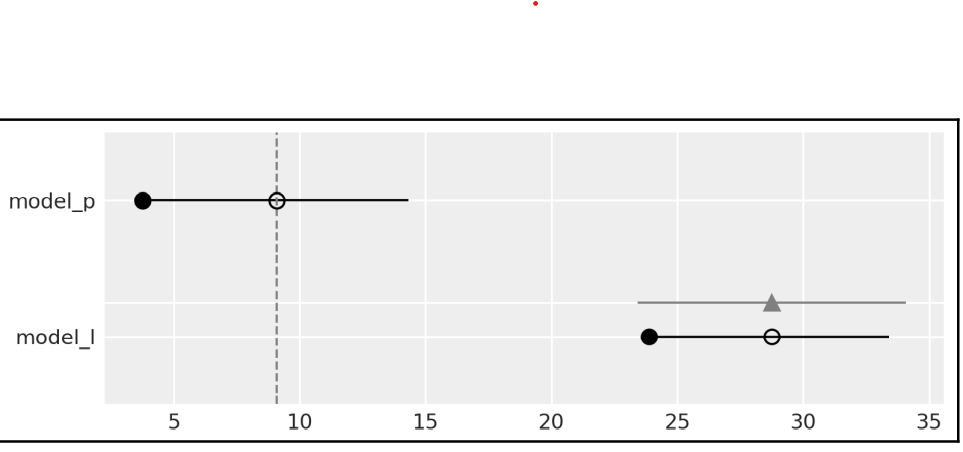




<h3>Regularizing priors</h3>


The root of overfitting is a model’s tendency to get overexcited by the training sample.When the priors are flat or nearly flat, the machine interprets this to mean that every parameter value is equally plausible. As a result, the model returns a posterior that encodes as much of the training sample—as represented by the likelihood function—as possible.

One way to prevent a model from getting too excited by the training sample is to use a
skeptical prior. By “skeptical,” I mean a prior that slows the rate of learning from the sample.

The most common skeptical prior is a regularizing prior. Such a prior, when tuned
properly, reduces overfitting while still allowing the model to learn the regular features of a
sample. If the prior is too skeptical, however, then regular features will be missed, resulting
in underfitting. So the problem is really one of tuning. But as you’ll see, even mild skepticism
can help a model do better, and doing better is all we can really hope for in the large world,
where no model nor prior is optimal.


Consider:  (Assume, as is good practice, that the predictor x is standardized so that its standard deviation
is 1 and its mean is zero)
yi ∼ Normal(µi, σ)
µi = α + βxi
α ∼ Normal(0, 100) ---> flat prior 
β ∼ Normal(0, 1)  ---- prior on β is narrower and is meant to regularize. The prior β ∼ Normal(0, 1)
                       says that, before seeing the data, the machine should be very skeptical of values
                       above 2 and below −2, as a Gaussian prior with a standard deviation of 1 assigns only                            5% plausibility to
                       values above and below 2 standard deviations.Because the predictor variable x 
                       is standardized, you can interpret this as meaning that a change of 1 standard deviation                          in x is very unlikely to produce 2 units of change in the outcome 
σ ∼ Exponential(1)

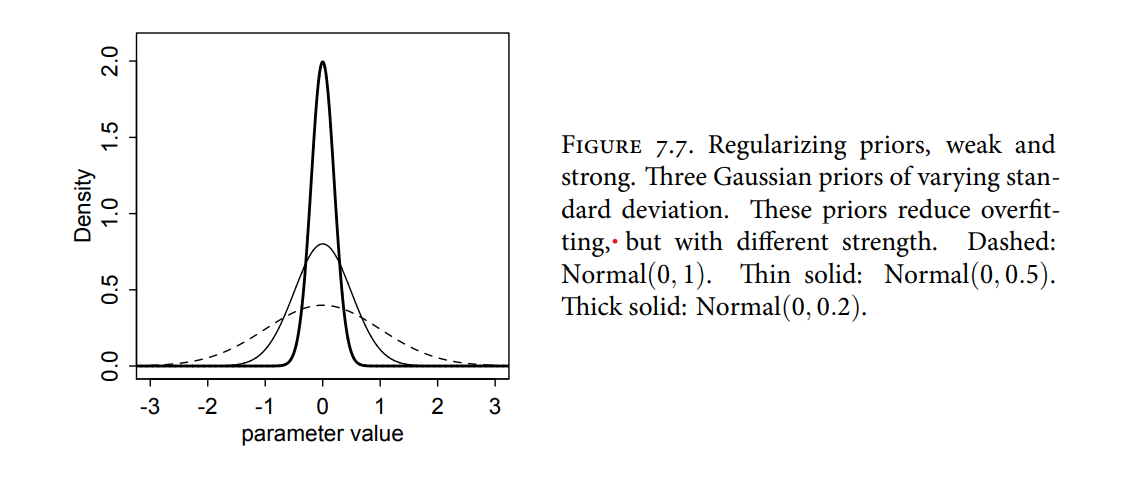